# Collision Physics

In this exercise, we'll explore the process of determining the consequences of a collision in Monte Carlo simulation.

In [101]:
import numpy as np
import matplotlib.pyplot as plt

Consider an infinite medium made up of a solution of the following composition:

| Element | Mass [g/mol] | Mass fraction |
|-------|------|-------|
|  H  |   1  |   0.1  |
|  O  |  16  |   0.84 |
|  Na |  23  |   0.03 |
|  Cl |  35.5 |  0.03 |

We'll approximate that all of these elements have a single isotope except chlorine, that is 50% $^{35}$Cl and 50% $^{36}$Cl by atom fraction.


## Activity

Determine the number density of each nuclide if the total density is 1 g/cm$^3$.

In [102]:
AVOGADRO_NUMBER = 6.02e23
BARNS_PER_CM3 = 1e24

element_N = {}

element_mass = { 'H' : 1, 'O': 16, 'Na' : 23 , 'Cl' : 35.5 }
element_mass_fraction = { 'H': 0.1, 'O' : 0.84 , 'Na' : 0.03, 'Cl' : 0.03}
abundance = { 'Cl' : { 35 : 0.5, 36: 0.5}}
density = 1

def nuclide_density(mass_density, element_mass, element_mass_fraction, abundance):
    """
    Calculate the number density of each nuclide 
    
    parameters
    ----------
    mass_density : (float) the mass density of the mixture in g/cm3
    element_mass : (dict{str:float}) elemental mass (value) of each element (key) in g/mol
    element_mass_fraction : (dict{str:float}) mass fraction (value) of each element (key)
    abundance : (dict{str:dict{int:float}}) atomic abundance (value) 
                    of each isotope (value-key) for each element (key)
                    
    returns
    --------
    dictionary with number density (value) for each element or isotope (key) in atoms/cm3
    """
    for element, element_mass in element_mass.items():
        element_rho = mass_density * element_mass_fraction[element]
        N = element_rho * AVOGADRO_NUMBER / element_mass
        if element in abundance:
            for mass_number, atom_fraction in abundance[element].items():
                element_N[f'{element}-{mass_number}'] = N * atom_fraction
        else:
            element_N[element] = N
    return element_N

N = nuclide_density(density, element_mass, element_mass_fraction, abundance)
for nuclide, num_dens in N.items():
    print(f'{nuclide:7} : {num_dens:.4g} atoms/cm^3 = {num_dens / BARNS_PER_CM3:.4g} atoms/b.cm')

H       : 6.02e+22 atoms/cm^3 = 0.0602 atoms/b.cm
O       : 3.16e+22 atoms/cm^3 = 0.0316 atoms/b.cm
Na      : 7.852e+20 atoms/cm^3 = 0.0007852 atoms/b.cm
Cl-35   : 2.544e+20 atoms/cm^3 = 0.0002544 atoms/b.cm
Cl-36   : 2.544e+20 atoms/cm^3 = 0.0002544 atoms/b.cm


## Activity 

The cross-sections for each nuclide, measured in barns, are defined for 0.001 eV < $E$ < 2 MeV:

|  Nuclide  |   $\sigma_a(E)$ | $\sigma_{el}(E)$ |
| :- | :- | :- |
|  $^1$H    | $\max(1/E, 0.01)$   | 0.5              |
| $^{16}$O  | $\max(0.05/E, 0.005)$ | 0.02             |
| $^{23}$Na | $\max(0.02/E, 0.002)$ | 0.01             |
| $^{35}$Cl | $\max(0.08/E, 0.1)$   | 0.01             |
| $^{36}$Cl | $\max(0.01/E, 0.001)$ | 0.005 &nbsp;&nbsp;&nbsp;           |

Determine the probability for each nuclide causing a collision if the energy of the neutron is:
* 1 eV
* 100 kEV


In [103]:
def sigma_a(E, slope, threshold):
    """
    Determines the absorption cross-section given the parameters
    that define the absorption cross-section
    
    parameters
    ----------
    E : (float) energy of incoming particle in eV
    slope : (float) slope of 1/E region of cross-section
    threshold : (float) minimum value of cross-section

    returns
    --------
    cross-section in barns
    """
    return max(slope/E, threshold)

def total_xs(E, N, sigma):
    """
    Calcualtes the total maroscopic cross-section for all nuclides over all reactions
    
    parameters
    ----------
    E : (float) energy of incoming particle in eV
    N : (dict{string:float}) number density (value) of each nuclide (key) in atoms/cm3
    sigma : (dict) cross-section data
    
    returns
    --------
    dictionary with macroscopic cross-section (value) for each nuclide (key)
    """
    Sigma = {}

    for nuclide, xs_data in sigma.items():
        Sigma[nuclide] = (sigma_a(E, xs_data['a'][0], xs_data['a'][1]) + xs_data['s']) * N[nuclide]
    
    return Sigma

def nuclide_probability(E, N, sigma):
    """
    Calculate the probability that a nuclide is involved in a collision
    at a given energy
    
    parameters
    -----------
    E : (float) energy of the particle in eV
    N : number density of each nuclide
    sigma : cross-section of each nucldie

    returns
    --------
    p : (dict) probability of each nuclide causing a collision
    """
    Sigma_tot = total_xs(E, N, sigma)
    
    total_Sigma = sum([val for val in Sigma_tot.values()])
    
    p = {}
    
    for nuclide, Sigma in Sigma_tot.items():
        p[nuclide] = Sigma/total_Sigma

    return p

sigma = {
    'H' : { 'a' : (1, 0.01), 's' : 0.5},
    'O' : { 'a' : (0.05, 0.005), 's' : 0.02},
    'Na' : { 'a' : (0.02, 0.002), 's' : 0.01},
    'Cl-35' : { 'a' : (0.08, 0.1), 's' : 0.01},
    'Cl-36' : { 'a' : (0.01, 0.001), 's' : 0.005},    
}

E_list = (1, 1e5)

for E  in E_list:
    p = nuclide_probability(E, N, sigma)

    print(f"Nuclide collision probability: E = {E} eV")
    for nuclide, prob in p.items():
        print(f'p({nuclide:5}): {prob:.5e}')
    print("")


Nuclide collision probability: E = 1 eV
p(H    ): 9.75502e-01
p(O    ): 2.38998e-02
p(Na   ): 2.54479e-04
p(Cl-35): 3.02268e-04
p(Cl-36): 4.12184e-05

Nuclide collision probability: E = 100000.0 eV
p(H    ): 9.73707e-01
p(O    ): 2.50586e-02
p(Na   ): 2.98836e-04
p(Cl-35): 8.87388e-04
p(Cl-36): 4.84030e-05



## Activity

If a collision with oxygen is selected for an energy of 100 eV, what's the probability that it will be a scattering reaction?

In [104]:
nuclide = 'O'
E = 100
xs_data = sigma[nuclide]
p_scattering = xs_data['s']/(xs_data['s'] + sigma_a(E, xs_data['a'][0], xs_data['a'][1]))
print(f'The probability of an {nuclide} scattering reaction with an enegy of {E} eV is {p_scattering:.5f}.')

The probability of an O scattering reaction with an enegy of 100 eV is 0.80000.


## Activity

1. Sample the scattering angle and determine the outgoing energy for a neutron scattering on oxygen at 25 keV.
2. Generate a histogram of the lab-frame scattering angle.


In [105]:
A = 16
E_in = 25e3

mu_c = np.random.rand() * 2 - 1
phi_c = np.arccos(mu_c) * 180/np.pi


mu_l = (1 + A * mu_c)/np.sqrt(A*A + 2*A*mu_c + 1)
E_ratio = (A*A + 2*A*mu_c + 1)/(1 + A)**2

phi_l = np.arccos(mu_l) * 180/np.pi
E_out = E_in * E_ratio

print(f"The particle leaves the reaction\n * with energy {E_out:.5e} eV "
      f"\n * at an angle of {phi_l:.3f} degrees to the incoming direction")

The particle leaves the reaction
 * with energy 2.08514e+04 eV 
 * at an angle of 116.712 degrees to the incoming direction


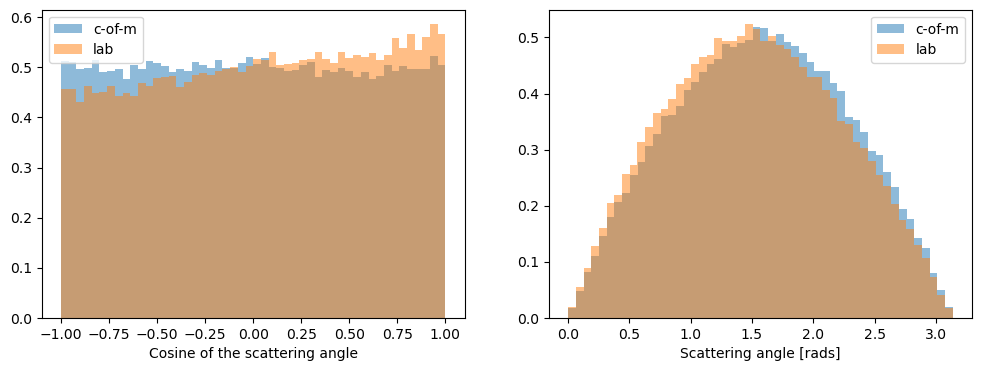

In [106]:
n_samples = 100000
n_bins=50
A=16
mu_c = np.random.rand(n_samples) * 2 - 1
mu_l = (1 + A * mu_c)/np.sqrt(A*A + 2*A*mu_c + 1)
phi_l = np.arccos(mu_l) * 180/np.pi

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(mu_c, n_bins, density=True, alpha=0.5, label='c-of-m' )
plt.hist(mu_l, n_bins, density=True, alpha=0.5, label='lab' )
plt.xlabel("Cosine of the scattering angle")
plt.legend()
plt.subplot(122)
plt.hist(np.arccos(mu_c), n_bins, density=True, alpha=0.5, label='c-of-m' )
plt.hist(np.arccos(mu_l), n_bins, density=True, alpha=0.5, label='lab' )
plt.xlabel("Scattering angle [rads]")
plt.legend()
plt.show()

## Activity

Write a function that samples the number of secondary particles that are generated by a reaction and show that it works for:
* $\nu = 3.465$
* $\nu = 1.954$


In [107]:
def sample_secondaries(nu):
    """
    Sample an integer number of secondaries for a non-integer parameter, 
    with an expected value equal to the non-integer value
    
    parameters
    ----------
    nu : (float) a non-integer number of secondaries that are generated on average
    
    returns
    --------
    integer number of secondaries generated in this instance
    
    """
    n_secondaries = np.floor(nu)
    if np.random.rand() < nu - n_secondaries:
        n_secondaries += 1
    return n_secondaries

n_samples = 10_000_000
for nu in (3.465, 1.954):
    sampled_secondaries = 0
    for _ in range(n_samples):
        sampled_secondaries += sample_secondaries(nu)
    print(f'The average number of secondaries sampled over {n_samples} samples is {sampled_secondaries/n_samples:.3f} vs nu={nu}')

The average number of secondaries sampled over 10000000 samples is 3.465 vs nu=3.465
The average number of secondaries sampled over 10000000 samples is 1.954 vs nu=1.954
